# Surface Defect Detection for MultiClass Dataset

## 1. Introduction

In this notebook, we are going to create a convolutional neural network (CNN) that can detect surface defects.
Previously we have used Torch but now PyTorch will be used.

PyTorch is the freshest flavour of the Torch. It combines customization of Torch with Python ease of use. It completely covers the Torch functionality, on top of that, new Autograd mechanism, dataset loaders and lots of utilities have been added for convenience.

## 2. Code

First, let's import required packages...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Spectral7
from bokeh.io import output_notebook
#from graphviz import Digraph
import numpy as np
import cnnUtils
import time
import copy
import os
import gc
import PIL
%matplotlib inline
plt.ion()
output_notebook()

Loading BokehJS ...

## 2.1 Dataset transformations
PyTorch lets us define a set of transformations to the loaded datasets. 

First images are converted to Torch tensors and then we will be scaling the images to 64 pixels in the smaller dimension. 

In [2]:
baseDirectory = 'f:/Datasets/'
setDirectory = 'MultiSet'
setImageSize = 128

# MultiSet mean and std values
#0.388710441743
#0.0605845721516
setMean = [0.388, 0.388, 0.388]
setStd = [0.06, 0.06, 0.06]

dataTransforms = {
    'train': transforms.Compose([
        transforms.Scale(setImageSize),
        transforms.RandomCrop(setImageSize),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=setMean, std=setStd)
    ]),
    'test': transforms.Compose([
        transforms.Scale(setImageSize),
        transforms.CenterCrop(setImageSize),
        transforms.ToTensor(),
        transforms.Normalize(mean=setMean, std=setStd)
    ]),
}

## 2.2 Loading datasets
Unlike Torch, PyTorch now supports direct image folder loading as the data. This completely removes the big dataset preparation step.

Additionally new dataset loaders allow setting batch size, shuffle and several other useful parameters.

Lastly checking the CUDA support is now easier with `torch.cuda.is_available()`

In [3]:
setPath = os.path.join(baseDirectory, setDirectory)
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(setPath, x), dataTransforms[x])
           for x in ['train', 'test']}

datasetLoaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=10, shuffle=True, num_workers=4)
                for x in ['train', 'test']}

testLoader = torch.utils.data.DataLoader(datasets['test'], batch_size=1, shuffle=False, num_workers=4)

datasetSizes = {x: len(datasets[x]) for x in ['train', 'test']}
datasetClasses = datasets['train'].classes

useGPU = torch.cuda.is_available()

print(str(datasetSizes) + ' images will be used.' )
print('GPU will ' + ('' if useGPU else 'not ') + 'be used.' )
print(str(len(datasetClasses)) + ' classes will be used.')

{'train': 2297, 'test': 1153} images will be used.
GPU will be used.
23 classes will be used.


## 2.3 Auxiliary functions

### 2.3.1 ImShow
Here we define the simple image displaying function and use the new dataset iterator to get one random batch to display it.

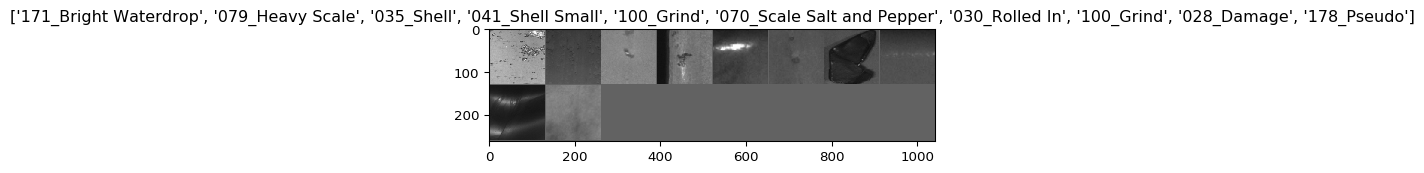

In [4]:
inputs, classes = next(iter(datasetLoaders['train']))
out = torchvision.utils.make_grid(inputs)
cnnUtils.ImShow(out, mean=setMean, std=setStd, title=[datasetClasses[x] for x in classes])
#print(inputs)

## 2.4 Training functions

This section contains functions used in training the network. First we should create the arrays to keep the error and learning rate changes.

In [5]:
trainLRValues = []
trainAccuracyTrain = []
trainAccuracyTest = []
trainErrorTrain = []
trainErrorTest = []

grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

## 2.5 Definition of neural network

### 2.5.1 Network module
Similar to Torch, here we define the neural network using separate modules.
First module handles the convolutional part of the network. After that a reshape operation adjust the convolution result for the following fully-connected layer module. Lastly, the result is applied to the fully-connected layer of the network and decisions are obtained with LogSoftMax operation in the end.

In [6]:
# Currently, weights are not shared.
# TODO: Try weight sharing with looping the element
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.reluIn = nn.ReLU()
        self.poolIn = nn.MaxPool2d(2, 2)
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.reluI2 = nn.ReLU()
        self.poolI2 = nn.MaxPool2d(2, 2)
        
        self.convI3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.reluI3 = nn.ReLU()
        self.poolI3 = nn.MaxPool2d(2, 2)
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.poolIn(self.reluIn(convInResult))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.poolI2(self.reluI2(convI2Result))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.poolI3(self.reluI3(convI3Result))
        
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x



#### 2.5.1.2 Batch normalization - TEST

In [7]:
# Currently, weights are not shared.
# TODO: Try weight sharing with looping the element
class NetBN(nn.Module):
    def __init__(self):
        super(NetBN, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNIn = nn.BatchNorm2d(num_features=32)
        self.reluIn = nn.ReLU()
        self.poolIn = nn.MaxPool2d(2, 2)
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNI2 = nn.BatchNorm2d(num_features=32)
        self.reluI2 = nn.ReLU()
        self.poolI2 = nn.MaxPool2d(2, 2)
        
        self.convI3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNI3 = nn.BatchNorm2d(num_features=32)
        self.reluI3 = nn.ReLU()
        self.poolI3 = nn.MaxPool2d(2, 2)
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(4096, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.poolIn(self.reluIn(self.batNIn(convInResult)))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.poolI2(self.reluI2(self.batNI2(convI2Result)))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.poolI3(self.reluI3(self.batNI3(convI3Result)))
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

#### 2.5.1.4 Batch normalization + SELU + AlphaDropout

In [8]:
# Currently, weights are not shared.
# TODO: Try weight sharing with looping the element
class NetBNSELU(nn.Module):
    def __init__(self):
        super(NetBNSELU, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNIn = nn.BatchNorm2d(num_features=32)
        self.seluIn = SELU()
        self.poolIn = nn.MaxPool2d(2, 2)
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNI2 = nn.BatchNorm2d(num_features=32)
        self.seluI2 = SELU()
        self.poolI2 = nn.MaxPool2d(2, 2)
        
        self.convI3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batNI3 = nn.BatchNorm2d(num_features=32)
        self.seluI3 = SELU()
        self.poolI3 = nn.MaxPool2d(2, 2)
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 4096),
            SELU(),
            AlphaDropout(p=0.5),
            nn.Linear(4096, 4096),
            SELU(),
            AlphaDropout(p=0.5),
            nn.Linear(4096, 4096),
            SELU(),
            AlphaDropout(p=0.5),
            nn.Linear(4096, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.poolIn(self.seluIn(self.batNIn(convInResult)))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.poolI2(self.seluI2(self.batNI2(convI2Result)))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.poolI3(self.seluI3(self.batNI3(convI3Result)))
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

#### 2.5.1.5 OptimNet

In [9]:
class NetBNOptim(nn.Module):
    def __init__(self):
        super(NetBNOptim, self).__init__()
        self.convIn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.batNIn = nn.BatchNorm2d(num_features=32)
        self.reluIn = nn.ReLU()
        self.poolIn = nn.MaxPool2d(2, 2)
        
        self.convI2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.batNI2 = nn.BatchNorm2d(num_features=64)
        self.reluI2 = nn.ReLU()
        self.poolI2 = nn.MaxPool2d(2, 2)
        
        # Out CH = 32 !
        self.convI3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.batNI3 = nn.BatchNorm2d(num_features=32)
        self.reluI3 = nn.ReLU()
        self.poolI3 = nn.MaxPool2d(2, 2)
        
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, len(datasetClasses))) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Convolutional layer 1
        convInResult = self.convIn(x)
        convInResult.register_hook(save_grad('convInGrad'))
        x = self.poolIn(self.reluIn(self.batNIn(convInResult)))
        
        # Convolutional layer 2
        convI2Result = self.convI2(x)
        convI2Result.register_hook(save_grad('convI2Grad'))
        x = self.poolI2(self.reluI2(self.batNI2(convI2Result)))
        
        # Convolutional layer 3
        convI3Result = self.convI3(x)
        convI3Result.register_hook(save_grad('convI3Grad'))
        x = self.poolI3(self.reluI3(self.batNI3(convI3Result)))
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

Now let's initialize the network and use GPU if possible.

In [10]:
# Regular net
#net = Net()

# Net with batch normalization layers, added approx ~1m per 10 epochs
#net = NetBN()

# Net with BN + SELU + AlphaDropout
#net = NetBNSELU()

# A smaller Net with batch normalization
#net = NetSmallBN()

# BN with optimized params
net = NetBNOptim()

#net = models.resnet50(pretrained=True)
#net.fc.out_features = len(datasetClasses)

if useGPU:
    net = net.cuda()

### 2.5.2 Criterion and optimizer
We successfully created our neural network. Now it is time to define a loss function and the optimizer.

In [11]:
criterion = nn.CrossEntropyLoss()
# try 0.03 weight_decay
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01, nesterov=True)
#optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.01)
#optimizer = optim.Adagrad(net.parameters(), lr=0.001, weight_decay=0.001)
optimizer = optim.RMSprop(net.parameters(), lr=0.0001, weight_decay=0.01)

lrScheduler = cnnUtils.StepLR(optimizer, step_size=3, gamma=0.85)

if useGPU:
    criterion = criterion.cuda()

## 2.6 Training

Mini-batch training method is preferred with PyTorch. It converges faster than the batch training method.

*Example*

*Mini-batch : With GTX 1070, 50 epochs train in 6m8s with 92.1% train and 93.9% test accuracy.*

*Batch      : With GTX 1070, 80 epochs train in 7m32s with 98.5% train and 99.3% test accuracy.*

In [12]:
cnnUtils.TrainModelMiniBatch(net, criterion, optimizer, lrScheduler, datasetLoaders, datasetSizes, trainAccuracyTrain, trainAccuracyTest, trainLRValues, 
                    trainErrorTrain, trainErrorTest, num_epochs=50)   

Epoch 0/49
----------
LR: [0.00011764705882352942]
train Loss: 0.2871 Acc: 0.1088
test Loss: 0.2848 Acc: 0.1310

Epoch 1/49
----------
LR: [0.0001]
train Loss: 0.2793 Acc: 0.1263
test Loss: 0.2731 Acc: 0.1657

Epoch 2/49
----------
LR: [0.0001]
train Loss: 0.2715 Acc: 0.1498
test Loss: 0.2624 Acc: 0.1587

Epoch 3/49
----------
LR: [0.0001]
train Loss: 0.2648 Acc: 0.1637
test Loss: 0.2516 Acc: 0.2099

Epoch 4/49
----------
LR: [8.5e-05]
train Loss: 0.2513 Acc: 0.1955
test Loss: 0.2324 Acc: 0.2567

Epoch 5/49
----------
LR: [8.5e-05]
train Loss: 0.2372 Acc: 0.2377
test Loss: 0.2278 Acc: 0.2741

Epoch 6/49
----------
LR: [8.5e-05]
train Loss: 0.2284 Acc: 0.2612
test Loss: 0.2145 Acc: 0.3001

Epoch 7/49
----------
LR: [7.225e-05]
train Loss: 0.2242 Acc: 0.2669
test Loss: 0.2124 Acc: 0.2966

Epoch 8/49
----------
LR: [7.225e-05]
train Loss: 0.2174 Acc: 0.2856
test Loss: 0.2056 Acc: 0.3287

Epoch 9/49
----------
LR: [7.225e-05]
train Loss: 0.2094 Acc: 0.3100
test Loss: 0.2027 Acc: 0.3513

Ep

RuntimeError: Traceback (most recent call last):
  File "I:\Anaconda3\envs\PyTorchEnv\lib\site-packages\torch\utils\data\dataloader.py", line 41, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "I:\Anaconda3\envs\PyTorchEnv\lib\site-packages\torch\utils\data\dataloader.py", line 110, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "I:\Anaconda3\envs\PyTorchEnv\lib\site-packages\torch\utils\data\dataloader.py", line 110, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "I:\Anaconda3\envs\PyTorchEnv\lib\site-packages\torch\utils\data\dataloader.py", line 90, in default_collate
    storage = batch[0].storage()._new_shared(numel)
  File "I:\Anaconda3\envs\PyTorchEnv\lib\site-packages\torch\storage.py", line 111, in _new_shared
    return cls._new_using_filename(size)
RuntimeError: Couldn't open shared file mapping: <torch_12136_2316648982>, error code: <1455> at D:\Downloads\pytorch-master-1\torch\lib\TH\THAllocator.c:154


In [27]:
#TrainModelBatch(net, criterion, optimizer, 0.000011875, maxIteration=80)
print(len(grads['convI3Grad']))

7


NetBNOptim (
  (convIn): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batNIn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (reluIn): ReLU ()
  (poolIn): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (convI2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batNI2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (reluI2): ReLU ()
  (poolI2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (convI3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batNI3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (reluI3): ReLU ()
  (poolI3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc): Sequential (
    (0): Linear (8192 -> 1024)
    (1): ReLU ()
    (2): Dropout (p = 0.5, inplace)
    (3): Linear (1024 -> 1024)
    (4): ReLU ()
    (5): Dropout (p = 0.5, inplace)
    (6): Linear (1024 -> 1024)
    (7): ReLU ()
    (8): Dropout (p = 0.5, inplace)
    (9): Linear (10

I:\Anaconda3\envs\PyTorchEnv\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


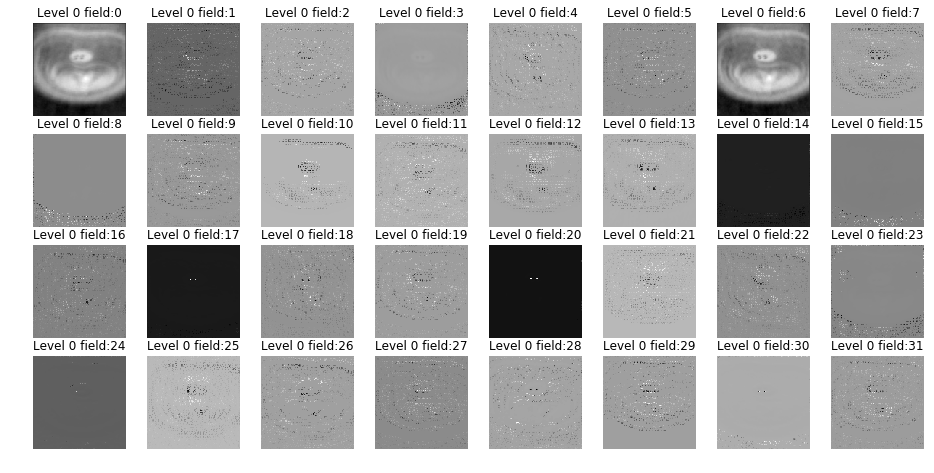

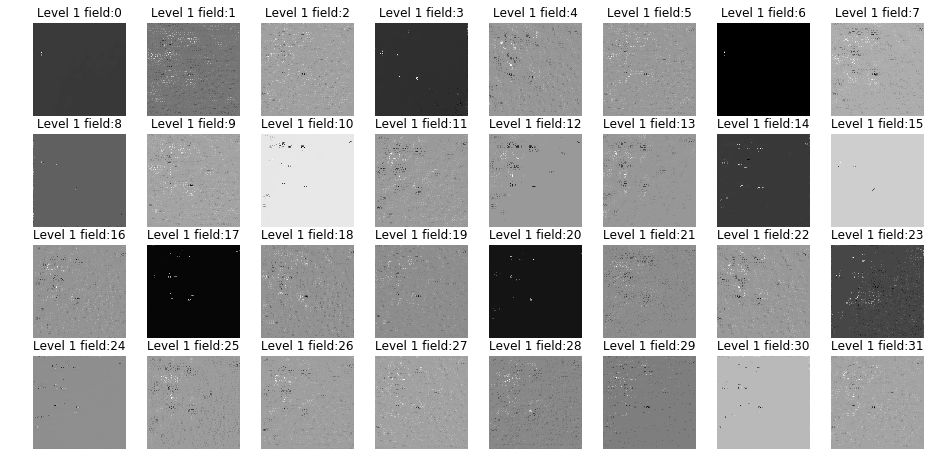

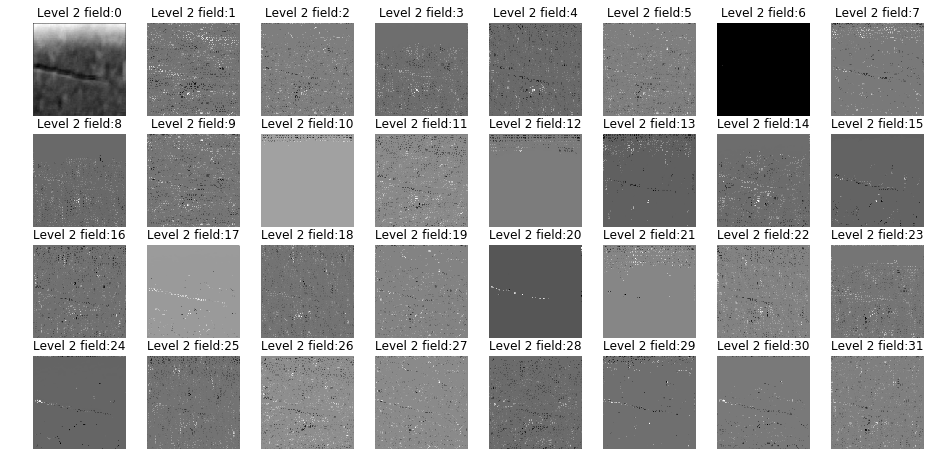

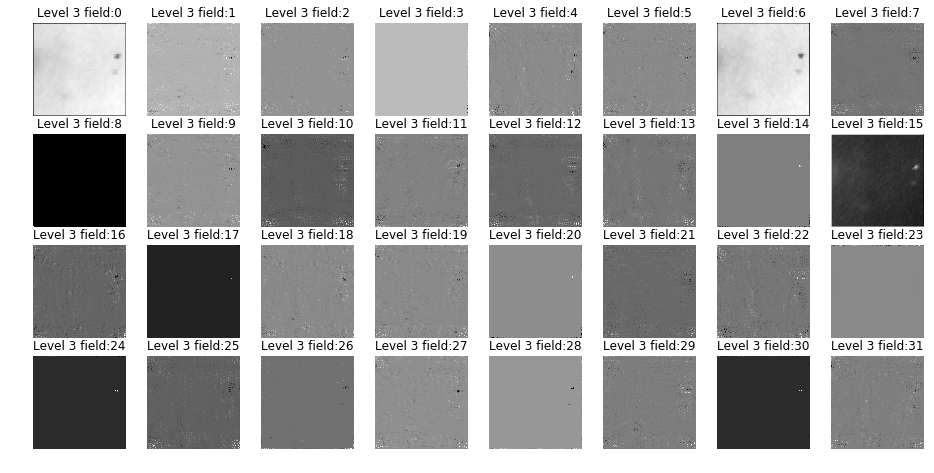

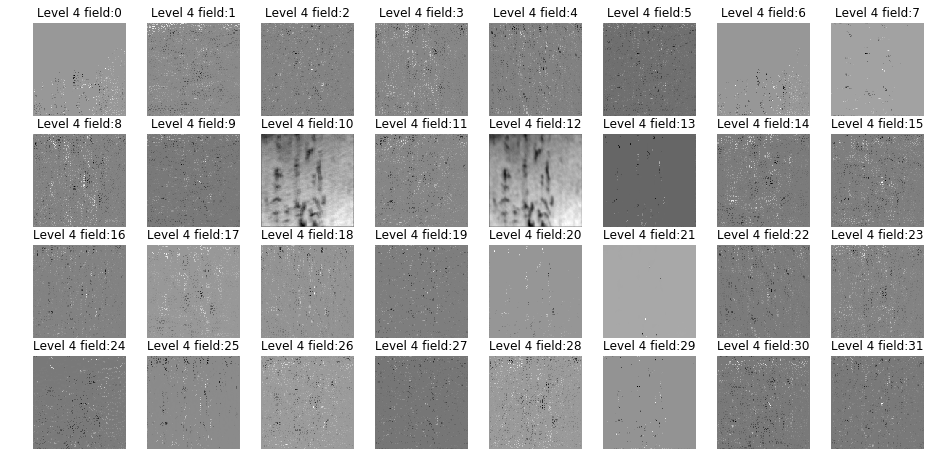

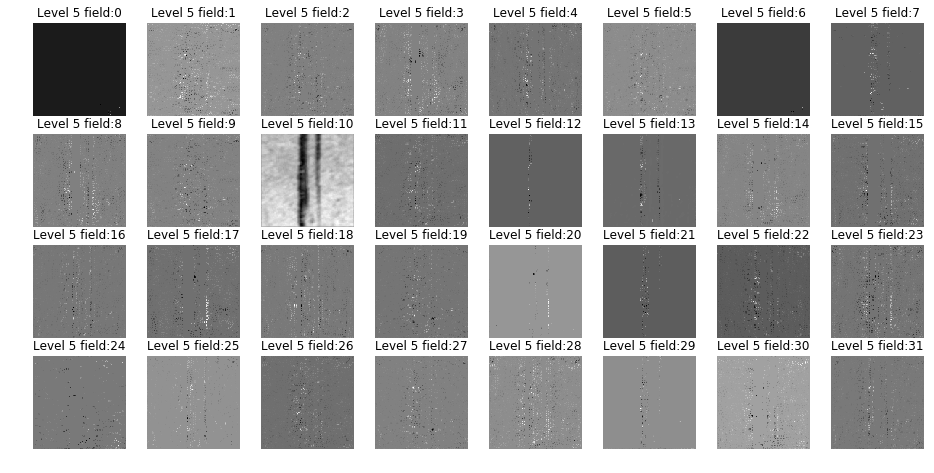

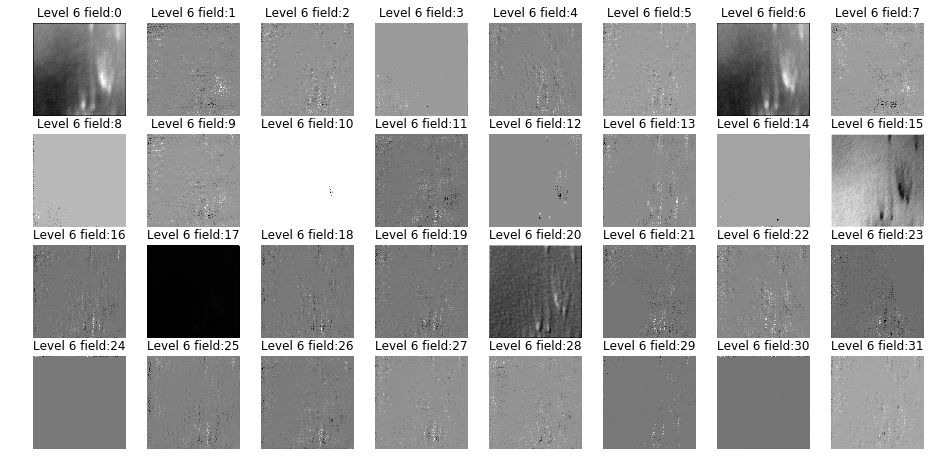

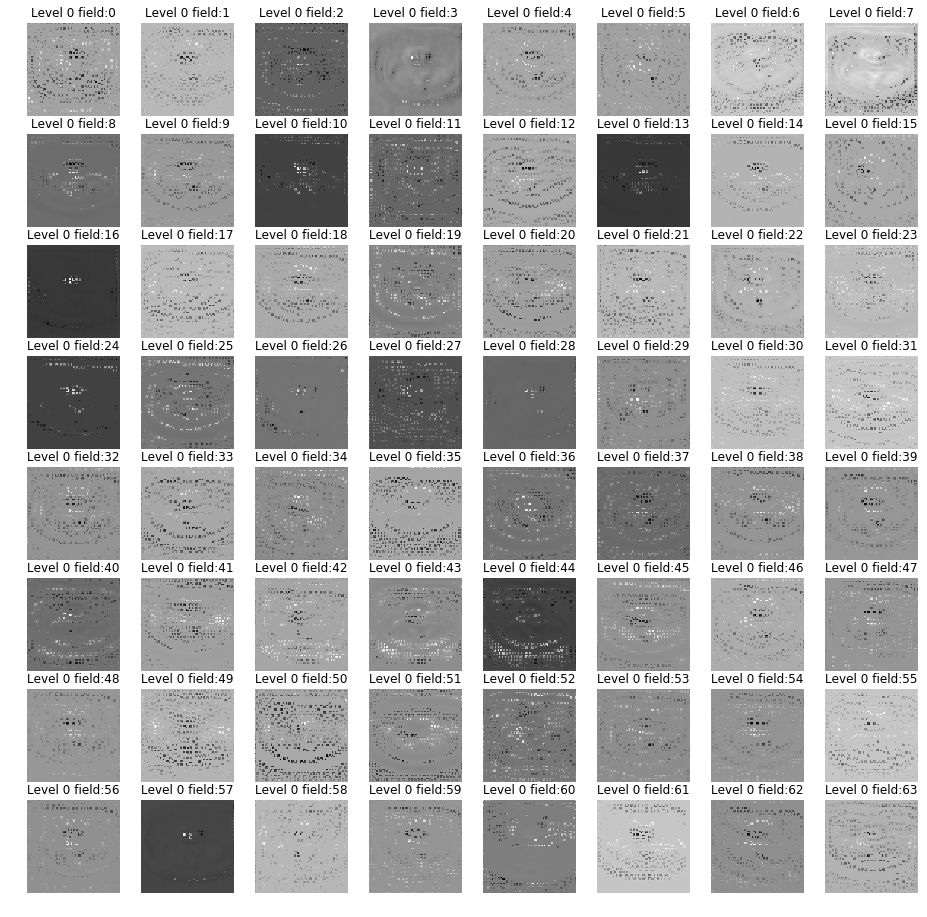

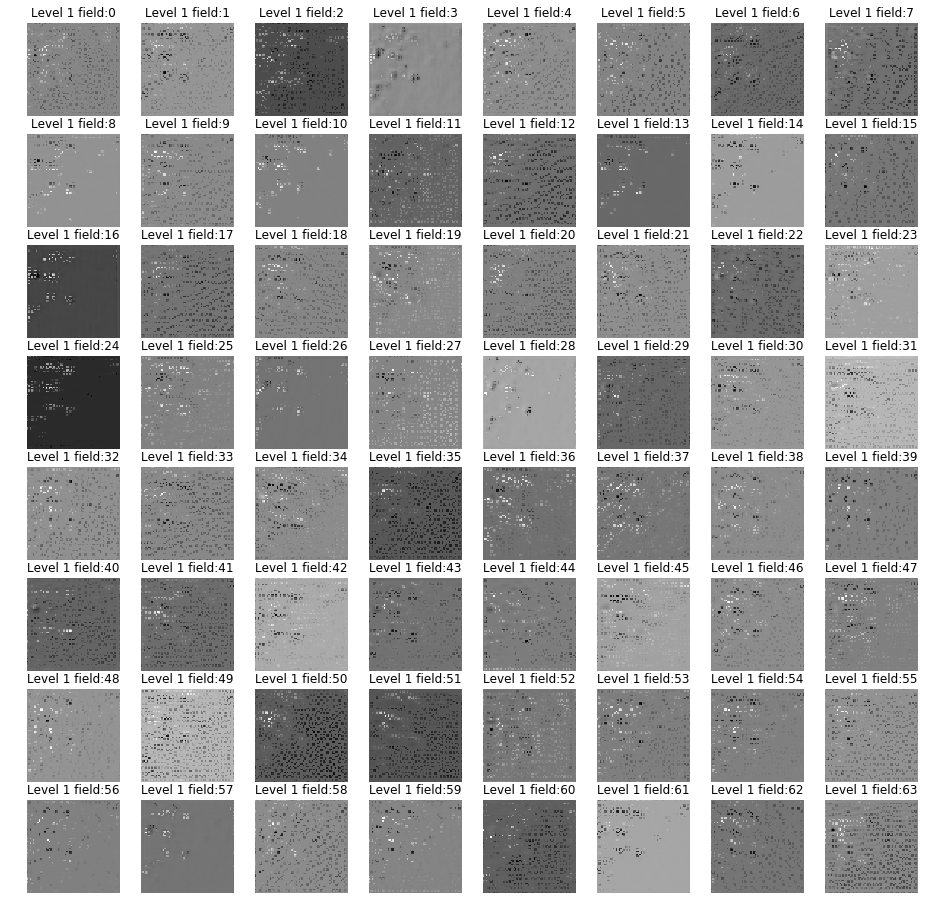

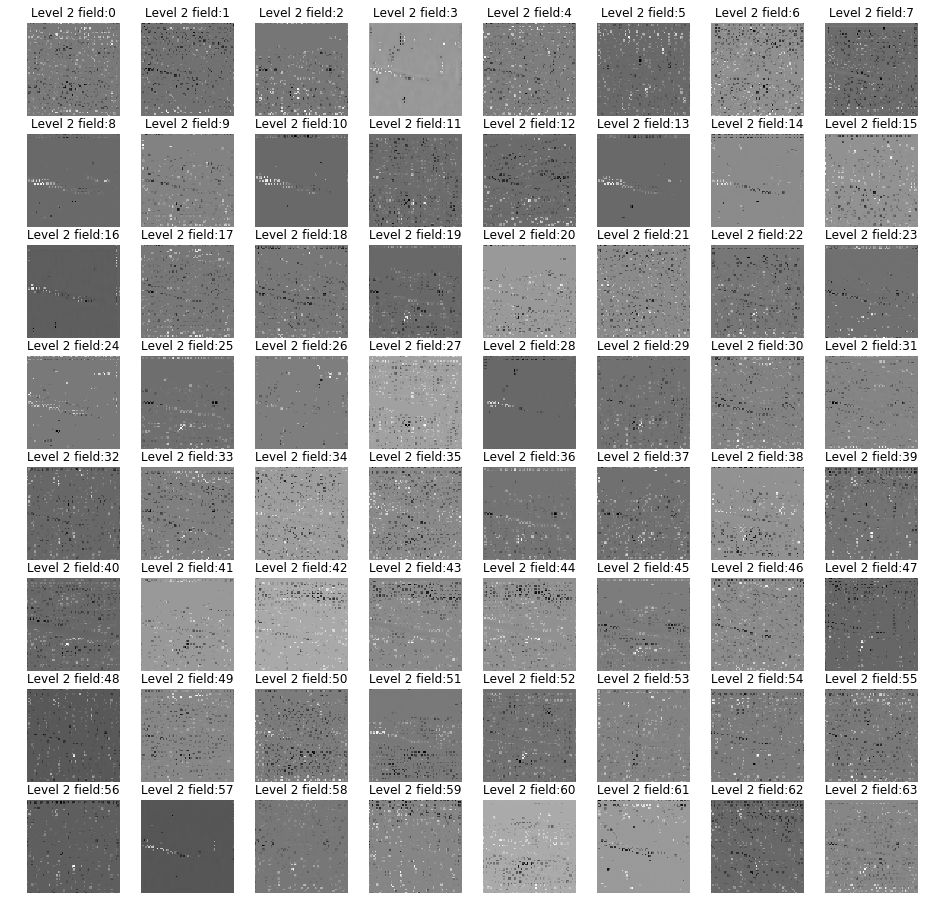

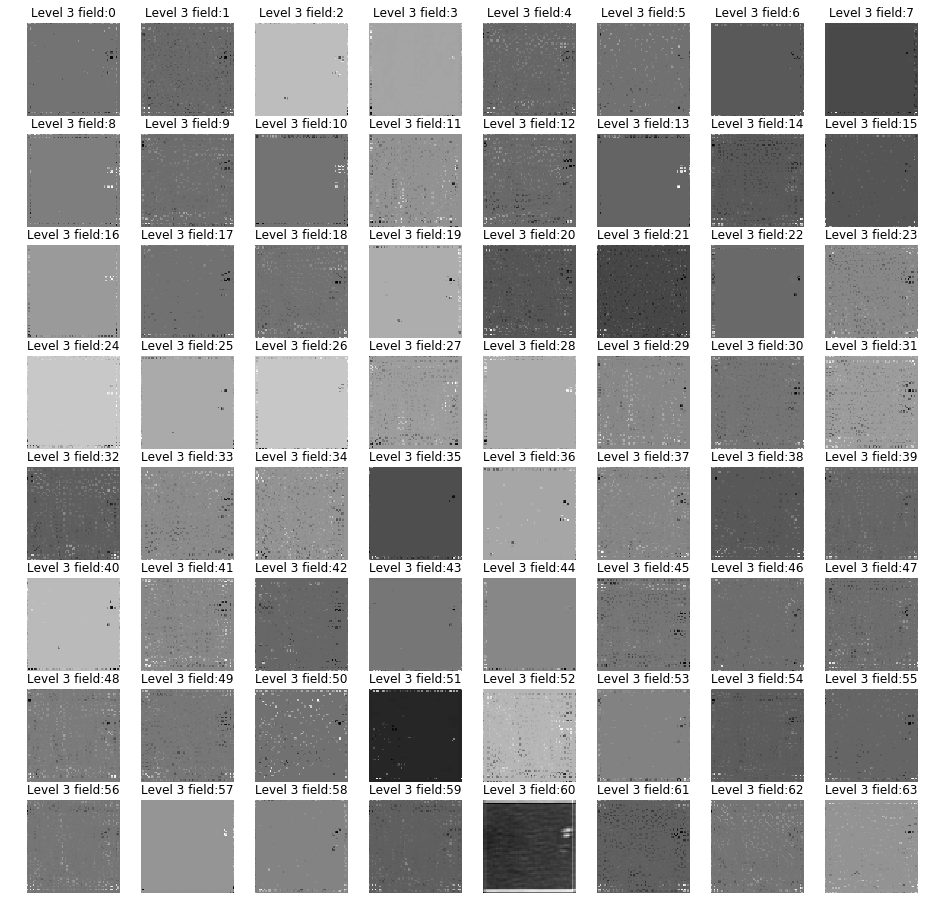

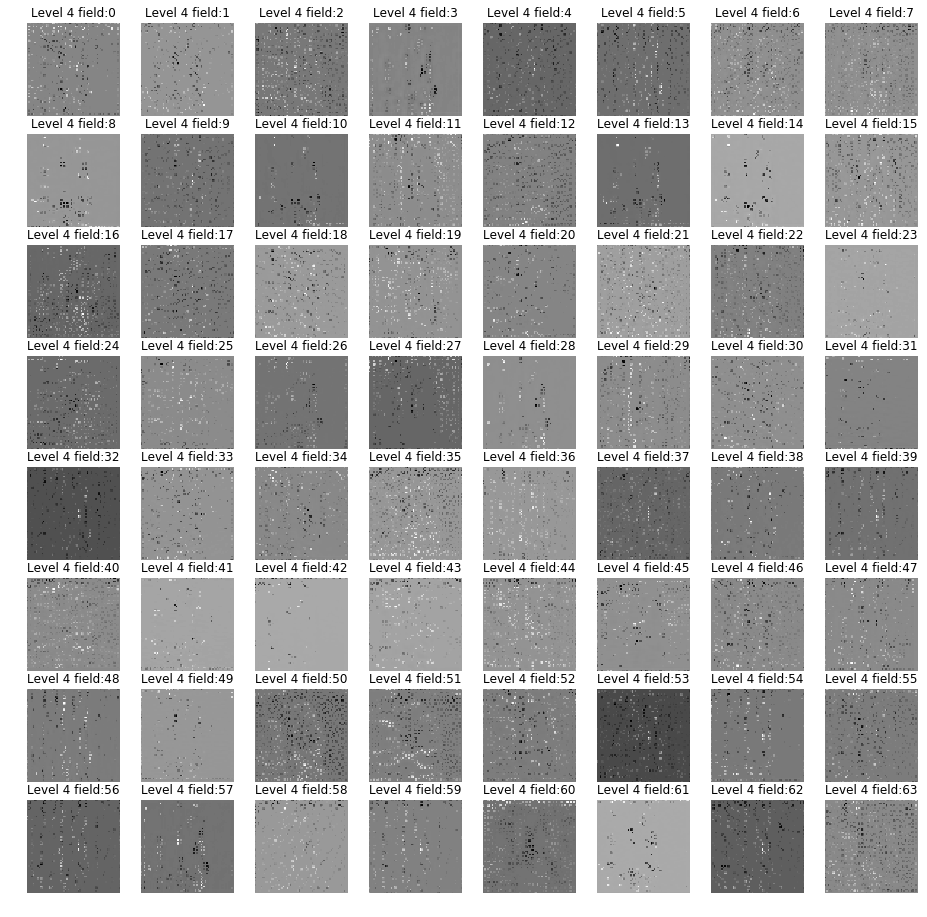

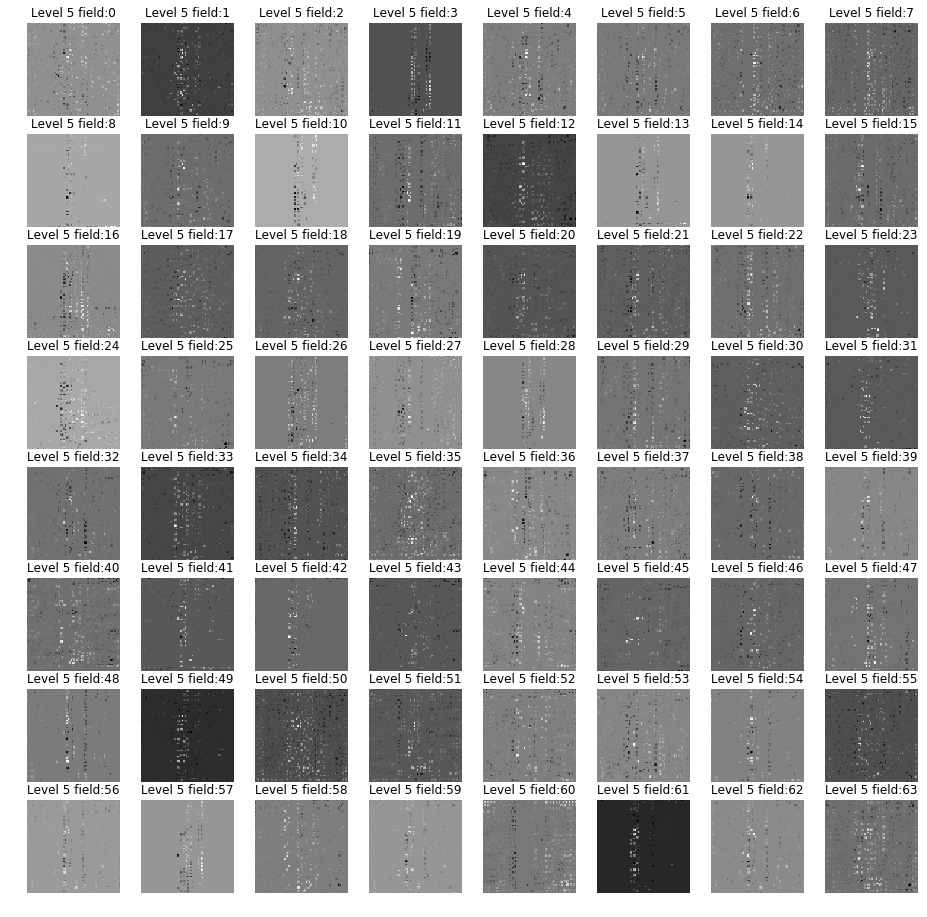

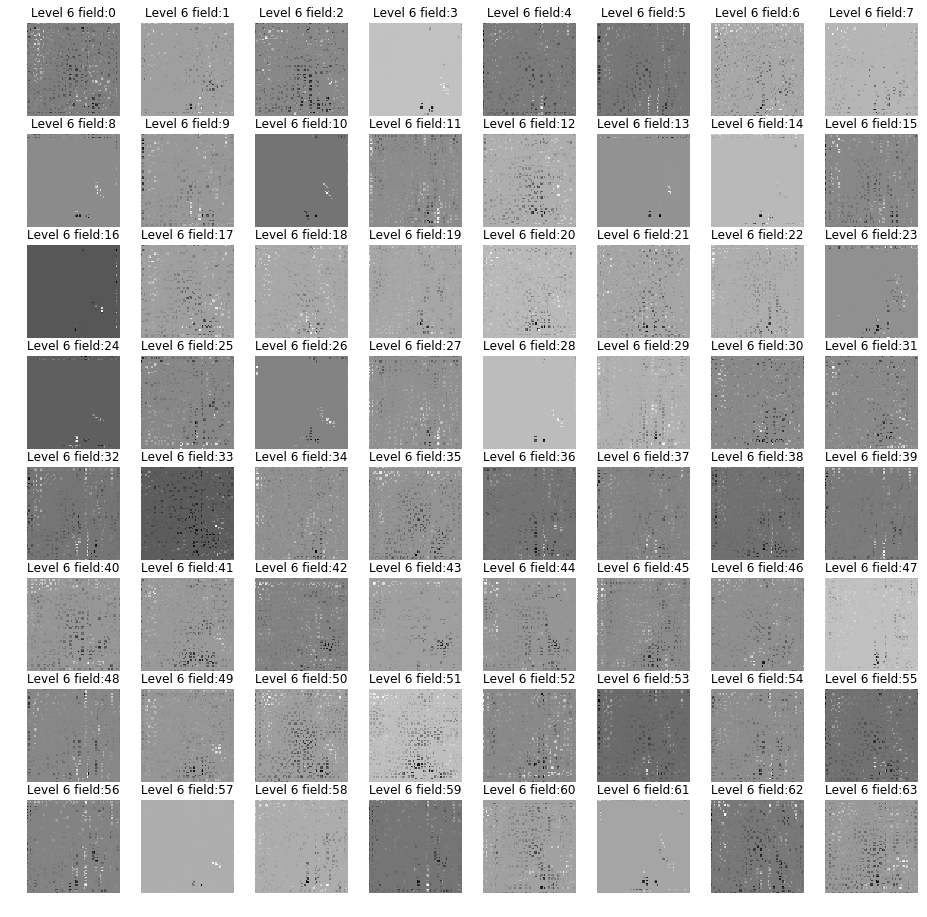

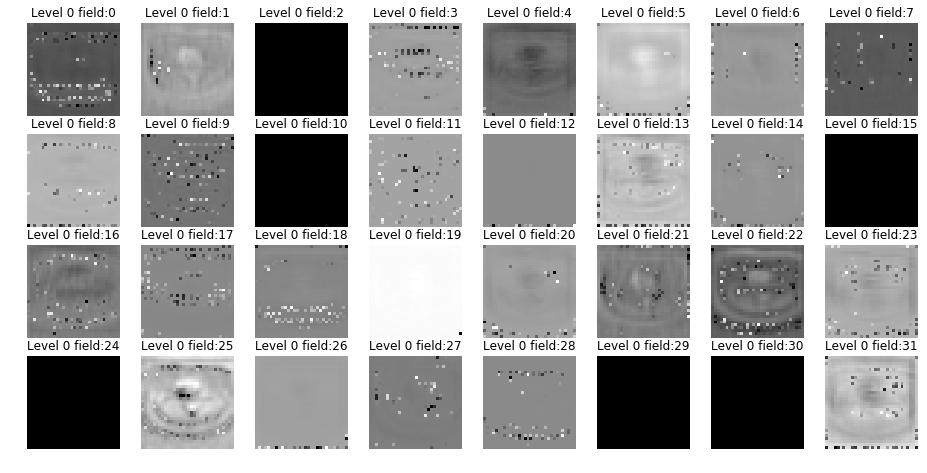

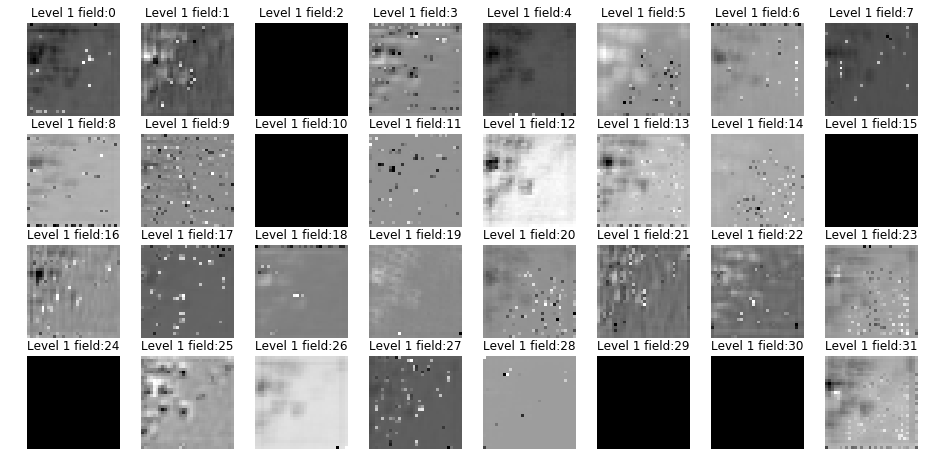

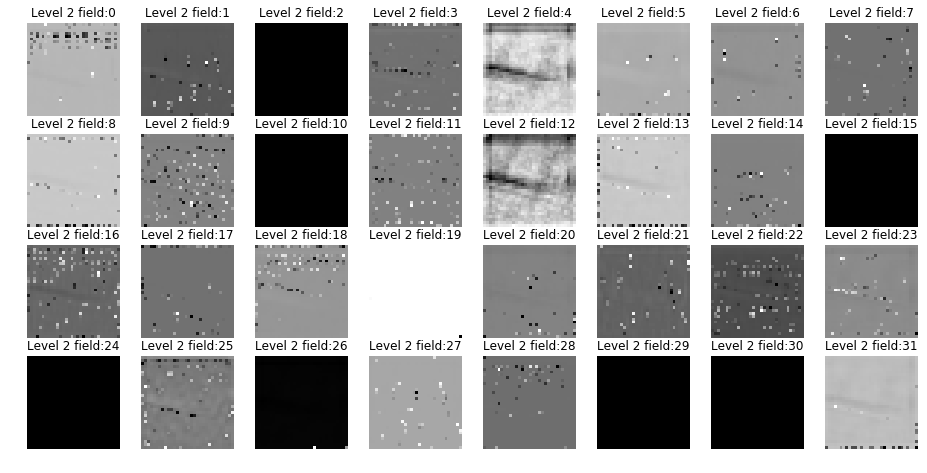

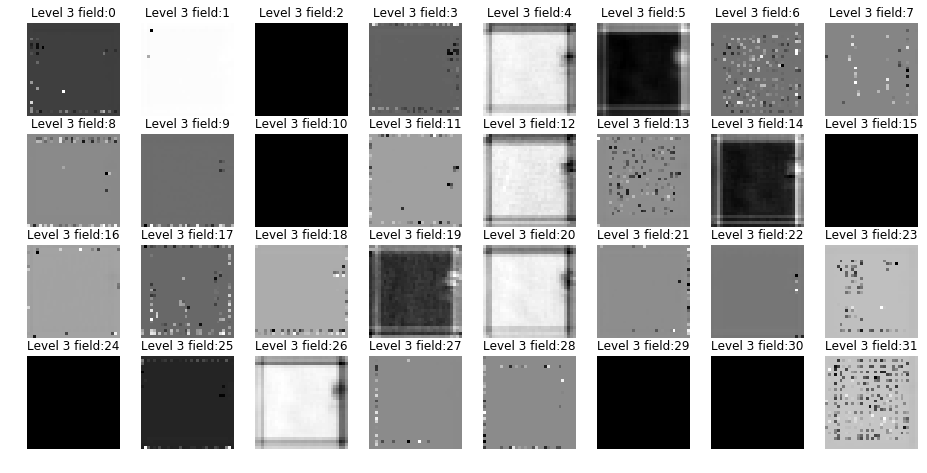

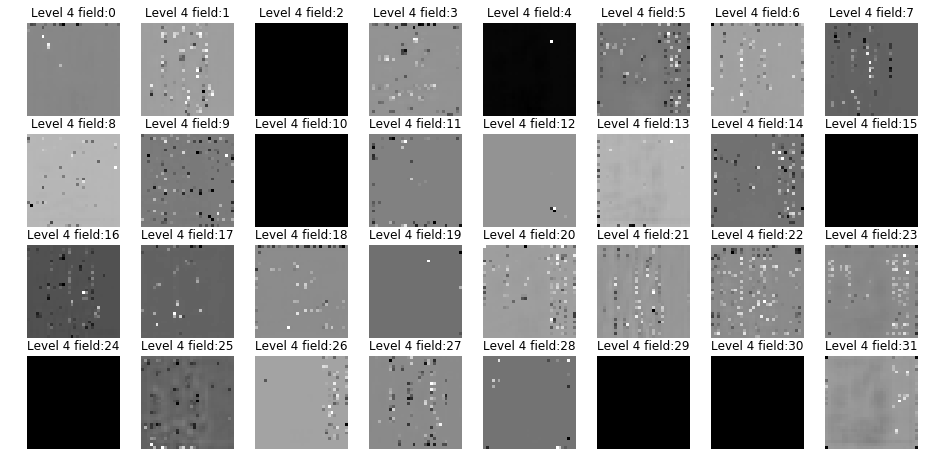

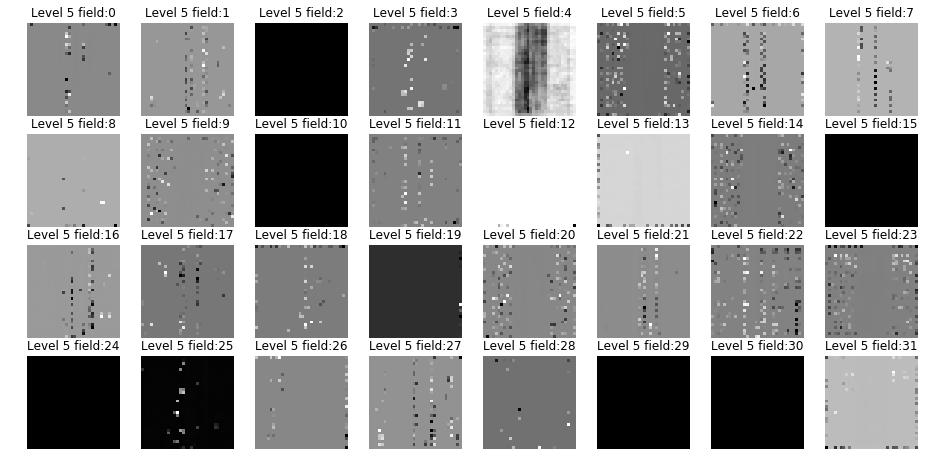

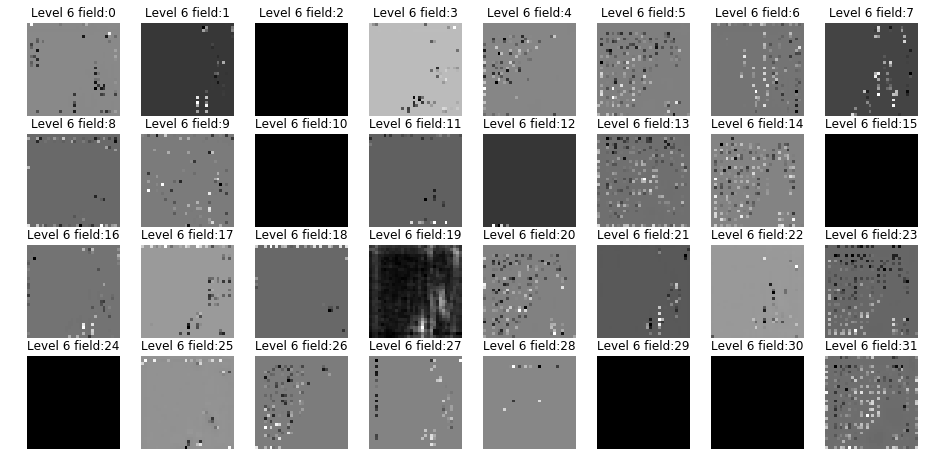

In [29]:
print(net)
gradIn = grads['convInGrad']
gradI2 = grads['convI2Grad']
gradI3 = grads['convI3Grad']

def PlotActivationMaps(gradients):
    for iT in range(gradients.size()[0]):
        plt.figure(figsize=(16, 16))
        for z in range(gradients.size()[1]):
            plt.subplot(8, 8, z+1)
            plt.title('Level ' + str(iT) + ' field:' + str(z))
            plt.axis('off')
            
            plt.imshow(gradients[iT, z, :, :].data.cpu().numpy(), interpolation='nearest', cmap='gray')
PlotActivationMaps(gradIn)
PlotActivationMaps(gradI2)
PlotActivationMaps(gradI3)

### 2.6.3 Visualization of the progress

In [30]:
def PlotArrays(arrays, labels, xlabel, ylabel, title):
    p = figure(title=title, x_axis_label=xlabel, y_axis_label=ylabel)
    length = len(arrays[0])
    palette = Spectral7[0:len(arrays)]
    x = np.linspace(0, length - 1, length)
    i = 0
    
    for array, label in zip(arrays, labels):
        p.circle(x, array, legend=label, fill_color=palette[i], line_color=palette[i])
        p.line(x, array, legend=label, line_color=palette[i], line_width=2)
        i += 1
    
    p.legend.location = 'bottom_left'
    show(p)

PlotArrays([trainErrorTrain, trainErrorTest], ['Training', 'Test'], xlabel='Epoch', ylabel='Loss', title='Loss over epoch')
PlotArrays([trainLRValues], ['Learning rate'], xlabel='Epoch', ylabel='Learning rate', title='Learning rate decrease')
PlotArrays([trainAccuracyTrain, trainAccuracyTest], ['Training accuracy', 'Test accuracy'], xlabel='Epoch', ylabel='Accuracy', title='Accuracy increase over epoch')

## 2.7 Visualization of the weights

This section is still in development.

In [31]:
#VisualizeModel(net)

In [32]:
# IN PROGRESS...
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
#plot_kernels(net.conv[6].weight.cpu().data.numpy())

In [38]:
import math
def plotNNFilter(units):
    print(units.shape)
    filters = units.shape[0]
    plt.figure(1, figsize=(6,6))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.axis('off')
        #plt.title('Filter ' + str(i))
        plt.imshow(units[i,0,:,:], interpolation="nearest", cmap="gray")

(32, 3, 5, 5)


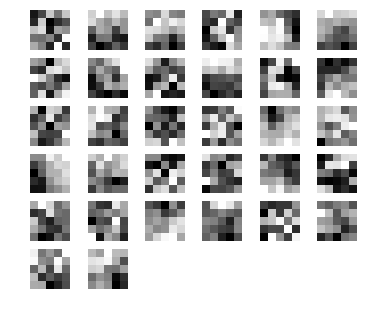

In [39]:
plotNNFilter(net.convIn.weight.cpu().data.numpy())

## 2.8 Evaluating network accuracy
Let's calculate the accuracy on the training set.

In [40]:
def DetermineAccuracy(phase):
    correct = 0
    total = 0
    for data in datasetLoaders[phase]:
        # Inputs
        inputs, labels = data
        if useGPU:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    return correct, total

In [41]:
correct, total = DetermineAccuracy('train')
print('Accuracy of the network for training set is {}%'.format(100 * correct / total))

Accuracy of the network for training set is 84.93687418371789%


Now time to see the accuracy of the test set.

In [42]:
correct, total = DetermineAccuracy('test')
print('Accuracy of the network for test set is {}%'.format(100 * correct / total))

Accuracy of the network for test set is 64.96097137901127%


Let's see individual class performance along with the confusion matrix.

Class 010_Hole total: 7.0 correct: 1.0 success rate is 14.285714285714286%
Class 015_Edge Crack total: 10.0 correct: 1.0 success rate is 10.0%
Class 027_Fold total: 12.0 correct: 5.0 success rate is 41.666666666666664%
Class 028_Damage total: 27.0 correct: 18.0 success rate is 66.66666666666667%
Class 030_Rolled In total: 67.0 correct: 44.0 success rate is 65.67164179104478%
Class 035_Shell total: 67.0 correct: 38.0 success rate is 56.71641791044776%
Class 039_Shell M total: 67.0 correct: 56.0 success rate is 83.58208955223881%
Class 041_Shell Small total: 100.0 correct: 59.0 success rate is 59.0%
Class 050_Roll Mark total: 100.0 correct: 75.0 success rate is 75.0%
Class 051_Bruise total: 15.0 correct: 3.0 success rate is 20.0%
Class 070_Scale Salt and Pepper total: 143.0 correct: 110.0 success rate is 76.92307692307692%
Class 079_Heavy Scale total: 20.0 correct: 12.0 success rate is 60.0%
Class 089_Scratch Bright total: 50.0 correct: 42.0 success rate is 84.0%
Class 100_Grind total: 1

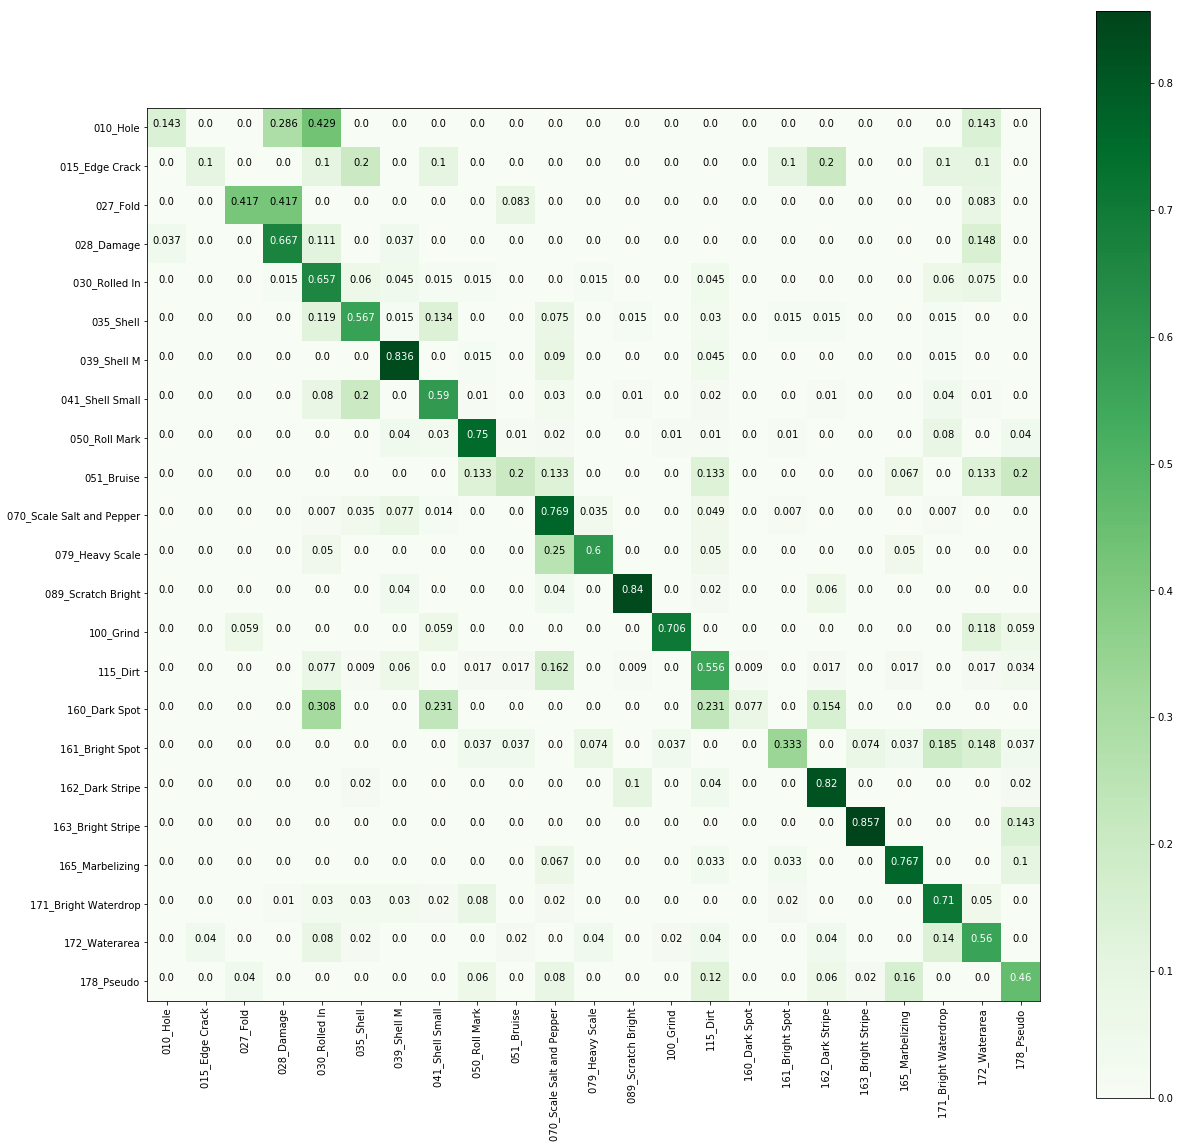

In [43]:
classCount = len(datasetClasses)
classCorrect = list(0. for i in range(classCount))
classTotal = list(0. for i in range(classCount))
confusion = torch.zeros(classCount, classCount)

for i, data in enumerate(testLoader):
    inputs, labels = data
    if useGPU:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)

    classTotal[labels.data.cpu().numpy()[0]] += 1
    confusion[labels.data.cpu().numpy()[0]][predicted[0][0]] += 1
    
    if labels.data.cpu().numpy()[0] == predicted.cpu().numpy()[0][0]:
        classCorrect[labels.data.cpu().numpy()[0]] += 1
    #else: # Display failure cases
        #out = torchvision.utils.make_grid(inputs.data.cpu())
        #ImShow(out, datasetClasses[labels.data.cpu()[0]])

for i, cls in enumerate(classCorrect):
    print('Class ' + datasetClasses[i] + ' total: ' + str(classTotal[i]) + ' correct: ' + str(classCorrect[i]) + ' success rate is ' + str(100 * classCorrect[i] / classTotal[i]) + '%') 

    
# Normalize confusion matrix
for i in range(classCount):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Plot confusion matrix
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
#cax = ax.matshow(confusion.numpy())
plt.imshow(confusion.numpy(), interpolation='nearest', cmap=plt.cm.Greens)
plt.colorbar()

ax.set_xticklabels([''] + datasetClasses, rotation=90)
ax.set_yticklabels([''] + datasetClasses)
thresh = confusion.max() / 2.0

for i in range(confusion.numpy().shape[0]):
    for j in range(confusion.numpy().shape[1]):
        plt.text(j, i, np.around(confusion[i,j], 3), horizontalalignment="center", color="white" if confusion[i, j] > thresh else "black")

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

Results are looking good, let's save the model for future use.

In [35]:
torch.save(net, 'EBA5CNN.net')

I:\Anaconda3\envs\PyTorchEnv\lib\site-packages\torch\serialization.py:147: UserWarning: Couldn't retrieve source code for container of type NetBN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
